## Mean Reversion Strategy with Bollinger Bands, RSI & MACD

Indicators: 
- Bollinger Bands (mean reversion)
- RSI: Relative Strength Index (momentum)
- MACD: Moving Average Convergence Divergence (trend confirmation)

## Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Download data

In [2]:
df = yf.download("AAPL", start="2020-01-01", end="2024-01-01", multi_level_index=False)
df = df[['Close']]
df.dropna(inplace=True)


C:\Users\Sanya Nanda\AppData\Local\Temp\ipykernel_70240\70100976.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2020-01-01", end="2024-01-01", multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


## 1. Bollinger Bands

- Bollinger Bands capture 2 standard deviations around a moving average.
- Used to detect price extremes (overbought/oversold).

In [3]:
# Indicator calculation
window = 20
df['MA20'] = df['Close'].rolling(window).mean()
df['STD20'] = df['Close'].rolling(window).std()
df['Upper'] = df['MA20'] + 2 * df['STD20']
df['Lower'] = df['MA20'] - 2 * df['STD20']

In [4]:
# Buy/Sell Signal logic
df['BB_Buy'] = df['Close'] < df['Lower']
df['BB_Sell'] = df['Close'] > df['Upper']

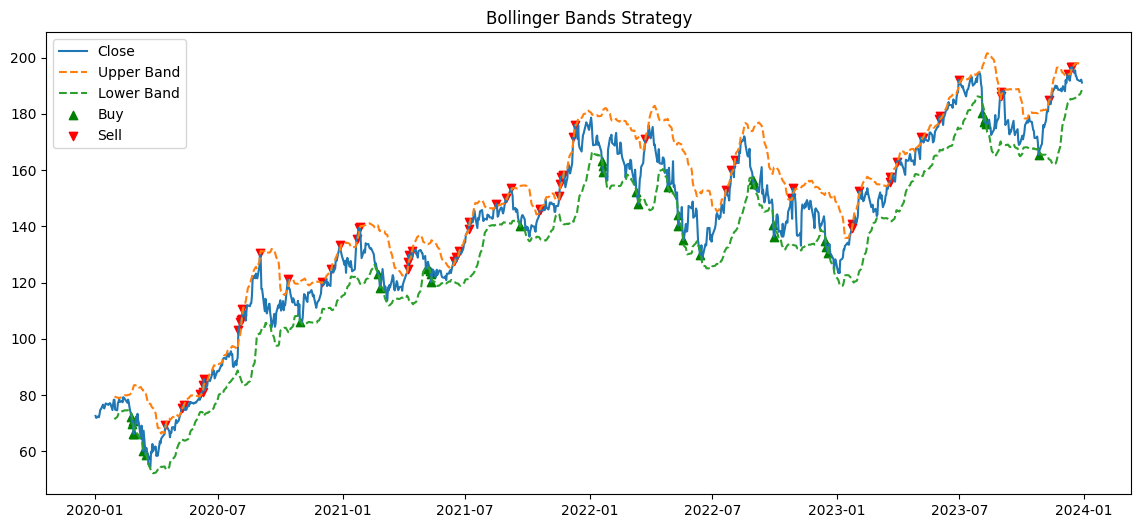

In [5]:
# Plot the signals
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close')
plt.plot(df['Upper'], label='Upper Band', linestyle='--')
plt.plot(df['Lower'], label='Lower Band', linestyle='--')
plt.scatter(df[df['BB_Buy']].index, df[df['BB_Buy']]['Close'], marker='^', color='green', label='Buy')
plt.scatter(df[df['BB_Sell']].index, df[df['BB_Sell']]['Close'], marker='v', color='red', label='Sell')
plt.title("Bollinger Bands Strategy")
plt.legend()
plt.show()


<Axes: title={'center': 'Bollinger Bands: Strategy vs Buy & Hold'}, xlabel='Date'>

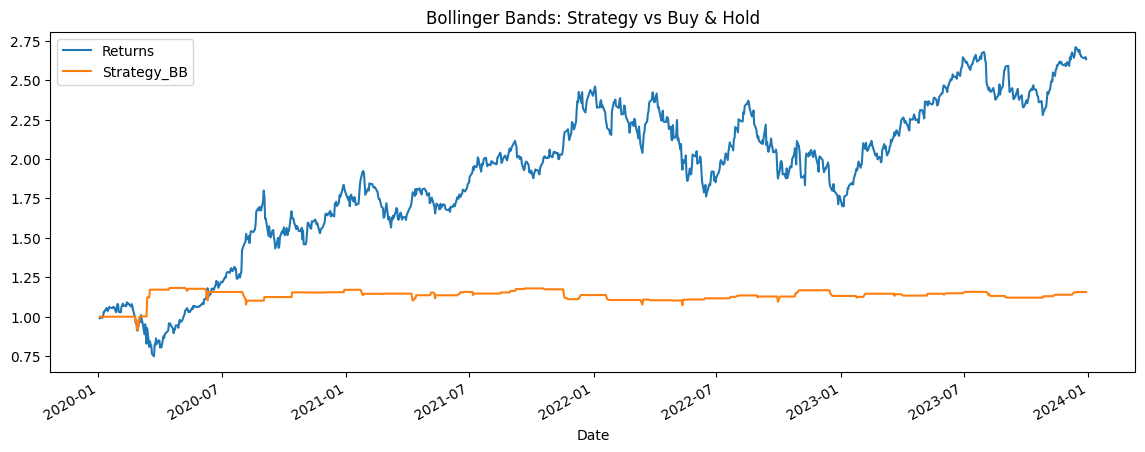

In [6]:
# Backtest Strategy
df['Position_BB'] = 0
df.loc[df['BB_Buy'], 'Position_BB'] = 1
df.loc[df['BB_Sell'], 'Position_BB'] = -1
df['Position_BB'] = df['Position_BB'].ffill().shift()

df['Returns'] = df['Close'].pct_change()
df['Strategy_BB'] = df['Position_BB'] * df['Returns']

(df[['Returns', 'Strategy_BB']] + 1).cumprod().plot(figsize=(14, 5), title="Bollinger Bands: Strategy vs Buy & Hold")


## Calculate RSI (Relative Strength Index)

- RSI measures speed and change of price movements.
- Bounded between 0 and 100: RSI < 30 = Oversold, RSI > 70 = Overbought


delta: price change between days

gain and loss: set negative values to 0 for gains and vice versa

rolling(...).mean(): computes the 14-day average


In [7]:
delta = df['Close'].diff()

gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean()

rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))


In [8]:
# Signal logic
df['RSI_Buy'] = df['RSI'] < 30
df['RSI_Sell'] = df['RSI'] > 70


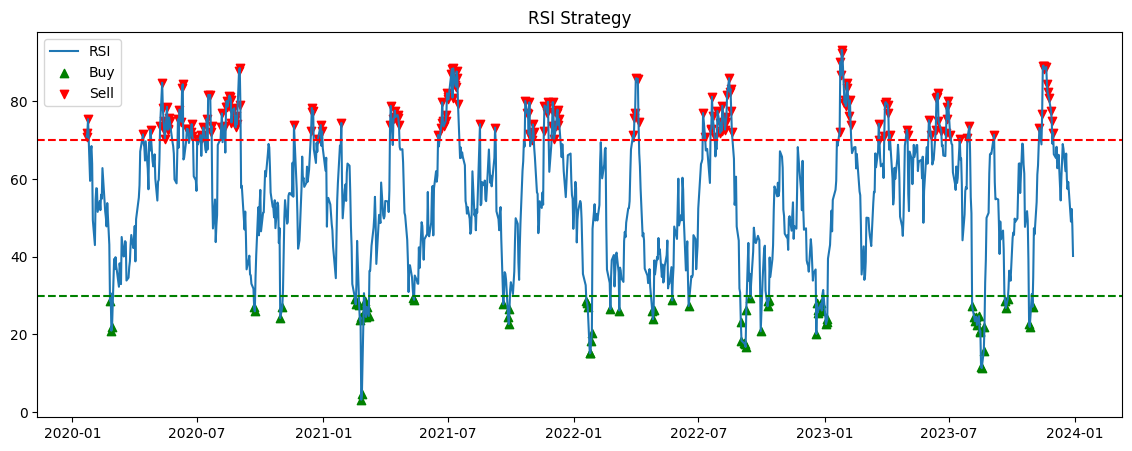

In [9]:
# Signal Plot
plt.figure(figsize=(14, 5))
plt.plot(df['RSI'], label='RSI')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.scatter(df[df['RSI_Buy']].index, df[df['RSI_Buy']]['RSI'], color='green', marker='^', label='Buy')
plt.scatter(df[df['RSI_Sell']].index, df[df['RSI_Sell']]['RSI'], color='red', marker='v', label='Sell')
plt.title("RSI Strategy")
plt.legend()
plt.show()


<Axes: title={'center': 'RSI: Strategy vs Buy & Hold'}, xlabel='Date'>

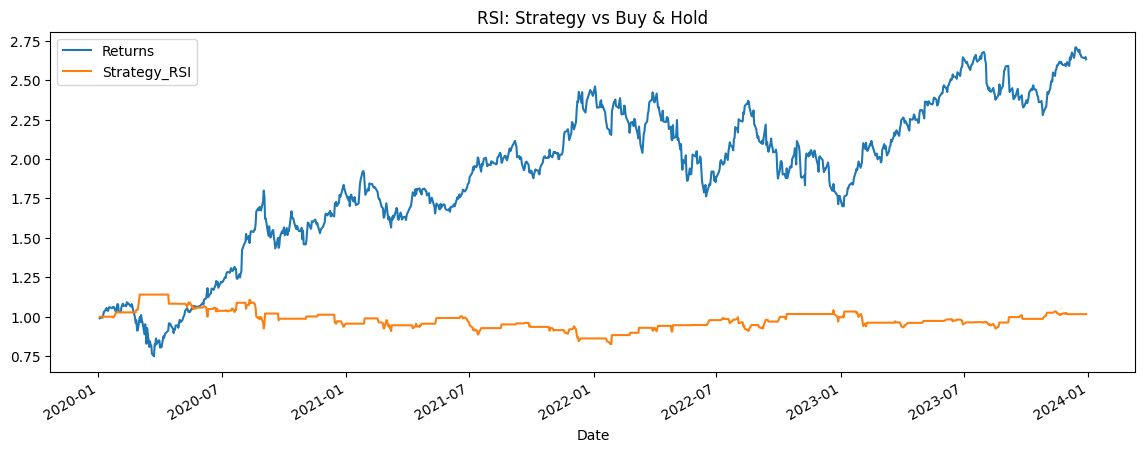

In [10]:
# Backtesting
df['Position_RSI'] = 0
df.loc[df['RSI_Buy'], 'Position_RSI'] = 1
df.loc[df['RSI_Sell'], 'Position_RSI'] = -1
df['Position_RSI'] = df['Position_RSI'].ffill().shift()

df['Strategy_RSI'] = df['Position_RSI'] * df['Returns']


(df[['Returns', 'Strategy_RSI']] + 1).cumprod().plot(figsize=(14, 5), title="RSI: Strategy vs Buy & Hold")


## Calculate MACD
- MACD is the difference between two EMAs.
- When MACD > Signal Line, it's a bullish signal.


In [11]:
# Indicator calculation
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()

df['MACD'] = ema_12 - ema_26
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()


In [12]:
# signal logic
df['MACD_Buy'] = (df['MACD'] > df['Signal']) & (df['MACD'].shift() <= df['Signal'].shift())
df['MACD_Sell'] = (df['MACD'] < df['Signal']) & (df['MACD'].shift() >= df['Signal'].shift())


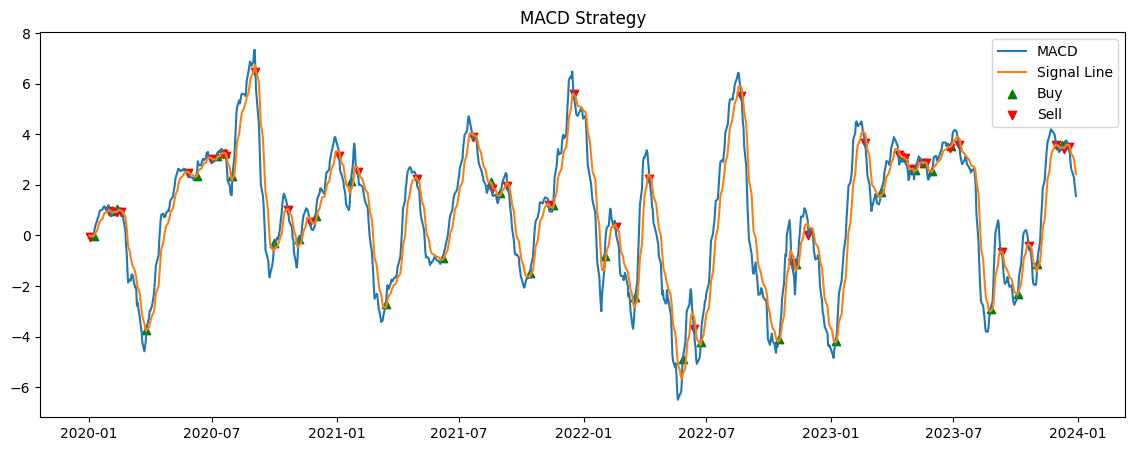

In [13]:
# signal plot
plt.figure(figsize=(14, 5))
plt.plot(df['MACD'], label='MACD')
plt.plot(df['Signal'], label='Signal Line')
plt.scatter(df[df['MACD_Buy']].index, df[df['MACD_Buy']]['MACD'], marker='^', color='green', label='Buy')
plt.scatter(df[df['MACD_Sell']].index, df[df['MACD_Sell']]['MACD'], marker='v', color='red', label='Sell')
plt.title("MACD Strategy")
plt.legend()
plt.show()


<Axes: title={'center': 'MACD: Strategy vs Buy & Hold'}, xlabel='Date'>

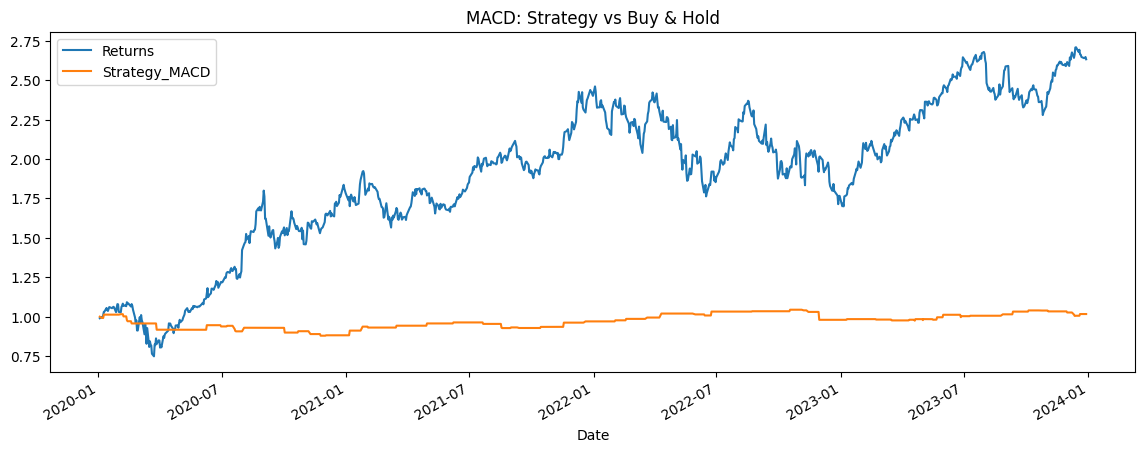

In [14]:
# backtesting
df['Position_MACD'] = 0
df.loc[df['MACD_Buy'], 'Position_MACD'] = 1
df.loc[df['MACD_Sell'], 'Position_MACD'] = -1
df['Position_MACD'] = df['Position_MACD'].ffill().shift()

df['Strategy_MACD'] = df['Position_MACD'] * df['Returns']

(df[['Returns', 'Strategy_MACD']] + 1).cumprod().plot(figsize=(14, 5), title="MACD: Strategy vs Buy & Hold")


## Summary

In [15]:
df.head()

,Close,MA20,STD20,Upper,Lower,BB_Buy,BB_Sell,Position_BB,Returns,Strategy_BB,...,RSI_Buy,RSI_Sell,Position_RSI,Strategy_RSI,MACD,Signal,MACD_Buy,MACD_Sell,Position_MACD,Strategy_MACD
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,72.620834,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,...,False,False,NaN,NaN,0.000000,0.000000,False,False,NaN,NaN
2020-01-03,71.914825,NaN,NaN,NaN,NaN,False,False,0.0,-0.009722,-0.0,...,False,False,0.0,-0.0,-0.056320,-0.011264,False,True,0.0,-0.000000
2020-01-06,72.487869,NaN,NaN,NaN,NaN,False,False,0.0,0.007968,0.0,...,False,False,0.0,0.0,-0.054090,-0.019829,False,False,-1.0,-0.007968
2020-01-07,72.146935,NaN,NaN,NaN,NaN,False,False,0.0,-0.004703,-0.0,...,False,False,0.0,-0.0,-0.078924,-0.031648,False,False,0.0,-0.000000
2020-01-08,73.307510,NaN,NaN,NaN,NaN,False,False,0.0,0.016086,0.0,...,False,False,0.0,0.0,-0.004900,-0.026299,True,False,0.0,0.000000


In [16]:
summary = {
    'Buy & Hold': (df['Returns'] + 1).prod() - 1,
    'Bollinger Band': (df['Strategy_BB'] + 1).prod() - 1,
    'RSI': (df['Strategy_RSI'] + 1).prod() - 1,
    'MACD': (df['Strategy_MACD'] + 1).prod() - 1
}
pd.DataFrame(summary, index=['Total Return (%)']).T * 100


,Total Return (%)
Buy & Hold,163.189382
Bollinger Band,15.647706
RSI,1.621625
MACD,1.692434


| Indicator                                        | Formula                                                                                                                                                             | Definition                                                                                                         | Application                                                                                                       |
| ------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------------------------------- |
| **Bollinger Bands**                              | - **MA:** $MA_t = \frac{1}{n} \sum_{i=0}^{n-1} P_{t-i}$ <br> - **Upper Band:** $UB = MA_t + k \cdot \sigma_t$ <br> - **Lower Band:** $LB = MA_t - k \cdot \sigma_t$ | A volatility-based indicator that defines upper/lower boundaries around a moving average using standard deviation. | Identifies overbought (price > UB) and oversold (price < LB) conditions. Common in **mean-reversion strategies**. |
| **RSI (Relative Strength Index)**                | $RSI = 100 - \left( \frac{100}{1 + RS} \right)$, where $RS = \frac{\text{avg gain}}{\text{avg loss}}$                                                               | A momentum oscillator that measures the speed and magnitude of recent price changes. Bounded between 0 and 100.    | Detects **momentum exhaustion**. RSI < 30 signals oversold (buy), RSI > 70 signals overbought (sell).             |
| **MACD (Moving Average Convergence Divergence)** | - $MACD = EMA_{12} - EMA_{26}$ <br> - $Signal = EMA_{9}(\text{MACD})$                                                                                               | Difference between short-term and long-term exponential moving averages. The signal line smooths the MACD.         | Captures **trend changes** and **momentum crossovers**. Buy when MACD > Signal; sell when MACD < Signal.          |



| Indicator | Common Use Cases                                                                  |
| --------- | --------------------------------------------------------------------------------- |
| **BB**    | Entry/exit for mean reversion strategies, volatility detection, channel breakouts |
| **RSI**   | Filtering signals, detecting reversal points, trading momentum extremes           |
| **MACD**  | Identifying trend continuation or early reversals, smoothing noisy data           |


## Potential hybrid of all the 3 indicators

### Strategy Logic (Hybrid):
Buy Signal:
1. Price touches or dips below Lower Bollinger Band
2. RSI < 30 → Oversold
3. MACD crossover upwards (MACD line crosses above signal line)

Sell Signal:
1. Price touches or rises above Upper Bollinger Band
2. RSI > 70 → Overbought
3. MACD crossover downwards

In [18]:
# df['Buy'] = (
#     (df['Close'] < df['Lower Band']) &
#     (df['RSI'] < 30) &
#     (df['MACD'] > df['Signal Line'])
# )

# df['Sell'] = (
#     (df['Close'] > df['Upper Band']) &
#     (df['RSI'] > 70) &
#     (df['MACD'] < df['Signal Line'])
# )